In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

Fake_dataset = pd.read_csv('fake.csv')
True_dataset = pd.read_csv('true.csv')

In [10]:
import torch
torch.cuda.is_available()

True

In [11]:
Fake_dataset.shape

(23481, 4)

In [12]:
True_dataset.shape

(21417, 4)

In [13]:
True_dataset['Output_'] = 1
Fake_dataset['Output_'] = 0

News = pd.concat([True_dataset,Fake_dataset])

News_input = News.drop('Output_',axis=1)
Result = News['Output_']

News_input = News.dropna()

News_input.reset_index(inplace=True)
News_input.head()

,index,title,text,subject,date,Output_
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [14]:
News = pd.concat([True_dataset,Fake_dataset])
News = News.drop('date', axis=1)

In [15]:
News_input['title']=News_input['title'].astype(str)
News_input['text']=News_input['text'].astype(str)

def lowercase(text):
    text=text.lower()
    return text

News_input['title']=News_input['title'].apply(lowercase)
News_input['text']=News_input['text'].apply(lowercase)

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import re

# cleaning the text data 

def text_clean(text):  
    text=re.sub("\[.*#&]"," ",text)
    text=re.sub("https?://\S+|www\.\S+","",text)
    text=re.sub("[^a-zA-Z0-9\s]+","",text)
    text = re.sub('\w*\d\w*', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()
    
    
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

   
    return text

News_input['title']= News_input['title'].apply(text_clean)
News_input['text']= News_input['text'].apply(text_clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rushabh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Now we import NLTK for Natural Language Processing

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.stem import SnowballStemmer

# initialize SnowballStemmer 
stemmer = SnowballStemmer('english')

def stem_text(text):
    # Tokenize the input text into individual words
    tokens = nltk.word_tokenize(text)
    
    # Stem each token using the SnowballStemmer
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    # Join the stemmed tokens back into a single string
    return ' '.join(stemmed_tokens)

# Apply stemming to the text data
News_input['title']= News_input['title'].apply(stem_text)
News_input['text']= News_input['text'].apply(stem_text)

News_input.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rushabh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rushabh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,index,title,text,subject,date,Output_
0,0,us budget fight loom republican flip fiscal sc...,washington reuter head conserv republican fact...,politicsNews,"December 31, 2017",1
1,1,us militari accept transgend recruit monday pe...,washington reuter transgend peopl allow first ...,politicsNews,"December 29, 2017",1
2,2,senior us republican senat let mr mueller job,washington reuter special counsel investig lin...,politicsNews,"December 31, 2017",1
3,3,fbi russia probe help australian diplomat tipo...,washington reuter trump campaign advis georg p...,politicsNews,"December 30, 2017",1
4,4,trump want postal servic charg much amazon shi...,seattlewashington reuter presid donald trump c...,politicsNews,"December 29, 2017",1


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

# Splitting the data into training and testing sets
train_data, test_data, train_data_output, test_data_output = train_test_split(News_input[['title', 'text']], Result, test_size=0.4, random_state=42)

# TF-IDF Vectorization
vectorization = TfidfVectorizer()
train_data_title_text = train_data['title'] + " " + train_data['text']
test_data_title_text = test_data['title'] + " " + test_data['text']

train_data_vectorized = vectorization.fit_transform(train_data_title_text)
test_data_vectorized = vectorization.transform(test_data_title_text)
X_train_vectorized = csr_matrix(train_data_vectorized)
X_test_vectorized = csr_matrix(test_data_vectorized)

In [19]:
import numpy as np

#We need to compute  𝑠𝑖𝑔𝑚𝑜𝑖𝑑(𝑤𝑇𝑥+𝑏) to make predictions

def sigmoid(z):

    S = 1 / (1 + np.exp(-z))

    return S

#We need to initialize w as a vector of zeros

def initialize_parameters(dim):
    
    w, b = np.zeros((dim,1)), 0
        
    return w,b
    

In [20]:
#Implementing a function propagate() that computes the cost function and its gradient

def propagate_batch(w, b, X_batch, Y_batch):
    m = X_batch.shape[1]
    # Convert the sparse matrix to a dense array
    X_dense = X_batch.toarray()
    # Compute the linear function
    Z = np.dot(w.T, X_dense) + b
    # Apply the sigmoid function
    A = sigmoid(Z)
    # Compute the cost
    cost = -1/m * np.sum(Y_batch * np.log(A) + (1 - Y_batch) * np.log(1 - A))
    # Compute the gradients
    dw = 1/m * np.dot(X_dense, (A - Y_batch).T)
    db = 1/m * np.sum(A - Y_batch)
    return dw, db, cost


In [21]:
#This function optimizes w and b by running a gradient descent algorithm. The goal is to learn 𝑤 and 𝑏 by minimizing the cost function J. For a parameter 𝜃, the update rule is 𝜃=𝜃−𝛼 𝑑𝜃 where 𝛼 is the learning rate
# Define optimization function with batch processing
def optimize_batch(w, b, X_train, Y_train, num_iterations, learning_rate, batch_size, print_cost=False):
    costs = []
    m = X_train.shape[1]
    
    for i in range(num_iterations):
        permutation = np.random.permutation(m)
        shuffled_X = X_train[:, permutation]
        shuffled_Y = Y_train[:, permutation]
        
        num_batches = m // batch_size
        for j in range(num_batches):
            start = j * batch_size
            end = min(start + batch_size, m)
            X_batch = shuffled_X[:, start:end]
            Y_batch = shuffled_Y[:, start:end]
            
            dw, db, cost = propagate_batch(w, b, X_batch, Y_batch)
            
            w -= learning_rate * dw
            b -= learning_rate * db
        
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
        
        costs.append(cost)
    
    return w, b, costs

In [22]:
# Define prediction function
def predict(w, b, X, batch_size=100):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Predict in batches 
    num_batches = (m + batch_size - 1) // batch_size
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, m)
        X_batch = X[:, start:end]
        
        
        X_dense = X_batch.toarray()
        A_batch = sigmoid(np.dot(w.T, X_dense) + b)
        Y_prediction[:, start:end] = (A_batch > 0.5).astype(int)
    
    return Y_prediction


In [23]:
# Define model function with batch processing
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, batch_size=64, print_cost=False):
    Y_train = np.array(train_data_output).reshape(1, -1)
    assert X_train.shape[1] == Y_train.shape[1], "Number of samples in X_train and Y_train are not equal"
    w, b = initialize_parameters(X_train.shape[0])
    w, b, costs = optimize_batch(w, b, X_train, Y_train, num_iterations, learning_rate, batch_size, print_cost)
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    train_accuracy = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_accuracy = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    print("Train accuracy: {} %".format(train_accuracy))
    print("Test accuracy: {} %".format(test_accuracy))
    model_info = {"w": w, "b": b, "costs": costs, "train_accuracy": train_accuracy, "test_accuracy": test_accuracy}
    return model_info


X_train = train_data_vectorized.T
Y_train = np.array(train_data_output)
X_test = test_data_vectorized.T
Y_test = np.array(test_data_output)



Y_train = Y_train.reshape(1, -1)

model_info = model(X_train, Y_train, X_test, Y_test, num_iterations=10, learning_rate=0.5, batch_size=64, print_cost=True)


Cost after iteration 0: 0.49013920299667424
Train accuracy: 96.1875417625659 %
Test accuracy: 95.9966592427617 %


Rushabh

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

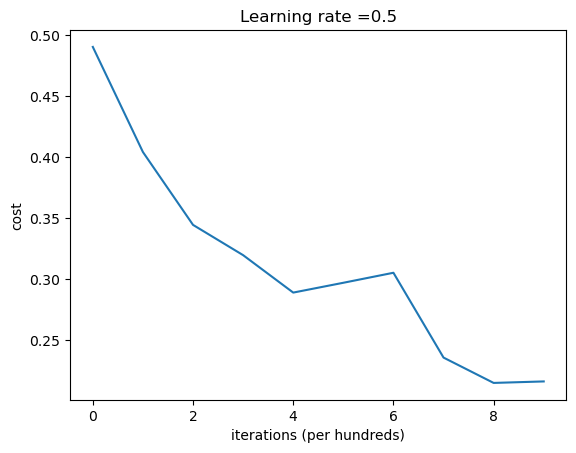

In [25]:
# Plot learning curve (with costs)
costs = np.squeeze(model_info['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(0.5))
plt.show()

<h1> Support Vector Machine </h1>

In [26]:
#Importing required libraries
import os
import numpy as np
import re
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.io import loadmat
import utils
%matplotlib inline

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [28]:
News = pd.concat([True_dataset, Fake_dataset])
News = News.drop('date', axis=1)

In [29]:
News.reset_index(inplace=True)

In [30]:
News['title'] = News['title'].astype(str)
News['text'] = News['text'].astype(str)


In [31]:
def text_clean(text):  
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)               # Remove special characters and numbers
    text = text.lower()                                   # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords
    text = ' '.join(filtered_words)
    text = re.sub('\s+', ' ', text).strip()  # Remove extra whitespace
    return text

In [32]:
News['title'] = News['title'].apply(text_clean)
News['text'] = News['text'].apply(text_clean)

In [33]:
from nltk.stem import SnowballStemmer

In [34]:
stemmer = SnowballStemmer('english')

In [35]:
def stem_text(text):
    tokens = nltk.word_tokenize(text)  # Tokenize the input text into individual words
    stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Stem each token
    return ' '.join(stemmed_tokens)  # Join the stemmed tokens back into a single string

In [36]:
News['title'] = News['title'].apply(stem_text)
News['text'] = News['text'].apply(stem_text)

In [37]:
vectorization = TfidfVectorizer()
title_text = News['title'] + " " + News['text']
vectorized_data = vectorization.fit_transform(title_text)
X = vectorized_data
Y = News['Output_'].values.ravel()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [39]:
from sklearn.svm import SVC

In [40]:
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier on the training set
svm_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = svm_classifier.predict(X_train)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Training Accuracy: 0.9986636226961412
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18831
           1       1.00      1.00      1.00     17087

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

Test Accuracy: 0.9952115812917595
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4650
           1       0.99      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
#Not sure why below is not working

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Range of values for the gamma parameter
gamma_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

for gamma in gamma_values:
    # Initialize SVM classifier with the Gaussian kernel and current gamma value
    svm_classifier = SVC(kernel='rbf', gamma=gamma)
    
    # Train the SVM classifier on the training set
    svm_classifier.fit(X_train, y_train)
    
    # Predictions on the training set
    y_train_pred = svm_classifier.predict(X_train)
    
    # Calculate accuracy on the training set
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Predictions on the test set
    y_test_pred = svm_classifier.predict(X_test)
    
    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plot the accuracy versus gamma parameter
plt.figure(figsize=(10, 6))
plt.plot(gamma_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(gamma_values, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy vs. Gamma Parameter (Gaussian Kernel)')
plt.xlabel('Gamma Parameter')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.xticks(gamma_values)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Range of values for the C parameter

def dataset3_params(X, y, Xval, yval):
    C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    sigma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    C = None
    sigma = None
    min_error = float('inf')
    
    # ====================== YOUR CODE HERE ======================
    for r in C_values:
        for s in sigma_values:
            model= utils.svmTrain(X, y, r, gaussian_kernel, args=(s,))
            predictions = utils.svmPredict(model, Xval)
            error = np.mean(predictions != yval)    
            if error < min_error:
                C = r
                sigma = s
                min_error = error
    # ============================================================
    return C, sigma

===============================================================
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier on the training set
svm_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = svm_classifier.predict(X_train)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

================================================================

# Lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

for C in C_values:
    # Initialize SVM classifier with the current C value
    svm_classifier = SVC(kernel='linear', C=C)
    
    # Train the SVM classifier on the training set
    svm_classifier.fit(X_train, y_train)
    
    # Predictions on the training set
    y_train_pred = svm_classifier.predict(X_train)
    
    # Calculate accuracy on the training set
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Predictions on the test set
    y_test_pred = svm_classifier.predict(X_test)
    
    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plot the accuracy versus C parameter
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(C_values, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy vs. C Parameter')
plt.xlabel('C Parameter')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.xticks(C_values)
plt.grid(True)
plt.legend()
plt.show()
